In [ ]:
# to run the program on a specific GPU. AS my GPU 0 is not available
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import torch
device = torch.device('cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/segmentation/AttentionUnet/')

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import random

from torch.autograd import Variable
from __future__ import print_function
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import os
from PIL import Image
import torchvision.transforms.functional as TF
import math
from skimage import filters
from skimage.color import rgb2gray
import time
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore")
import sys
!pip install xlsxwriter
import xlsxwriter
from torchvision.utils import save_image

     |████████████████████████████████| 149 kB 13.8 MB/s 


In [ ]:
#Loading Train data

class Isic_train_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Training_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Training_GroundTruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Training_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Training_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
#         img = img.resize((224, 224))
        mask = Image.open(mask_path)
#         mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [ ]:
#Loading Test data

class Isic_test_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Test_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Test_GroundTruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Test_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Test_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
#         img = img.resize((224, 224))
        mask = Image.open(mask_path)
#         mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            
        img_name = self.imgs[idx]
        return img, mask, img_name

    def __len__(self):
        return len(self.imgs)

In [ ]:
def my_segmentation_transforms(image):
    angle = 25
    image = TF.rotate(image, angle)
    return image

def scale_image(image):
#     scale = 1.2
    image = TF.affine(img=image, angle=0, translate=(0, 0), scale=1.3, shear=0)
    return image

transform1 = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])#transforms.Resize((224,224)),
transform2 = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(1), transforms.ToTensor()])
transform3 = transforms.Compose([transforms.Resize((224,224)), my_segmentation_transforms, transforms.ToTensor()])
transform4 = transforms.Compose([transforms.Resize((224,224)), scale_image, transforms.ToTensor()])

train_dataset     = Isic_train_Dataset('/content/drive/MyDrive/segmentation/AttentionUnet/one_result/', transforms=transform1)
horizontalflipped = Isic_train_Dataset('/content/drive/MyDrive/segmentation/AttentionUnet/one_result/', transforms=transform2)
rotated_image     = Isic_train_Dataset('/content/drive/MyDrive/segmentation/AttentionUnet/one_result/', transforms=transform3)
scaled_image      = Isic_train_Dataset('/content/drive/MyDrive/segmentation/AttentionUnet/one_result/', transforms=transform4)
# data Augmentation

increased_dataset = torch.utils.data.ConcatDataset([train_dataset, horizontalflipped, rotated_image, scaled_image])


test_dataset = Isic_test_Dataset('/content/drive/MyDrive/segmentation/AttentionUnet/one_result', transforms=transform1)

In [ ]:
#shape of train Data
img, mask = train_dataset[0]
print(img.size())
print(mask.size())

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


In [ ]:
# hyper-parameters
batch_size = 8

In [ ]:
lengths = [int(len(increased_dataset)*0.9), int(len(increased_dataset)*0.1)]
train_set, val_set = torch.utils.data.dataset.random_split(increased_dataset, lengths)

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# lengths of dataset
print('Length of original train data : ', len(train_set))
# print('Length of Training data       : ', len(increased_dataset))
print('Length of validation data     : ', len(val_set))
print('Length of Testing data        : ', len(test_dataset))

Length of original train data :  3240
Length of validation data     :  360
Length of Testing data        :  379


# visualizing Data

    1.Visualizing Train Data

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])


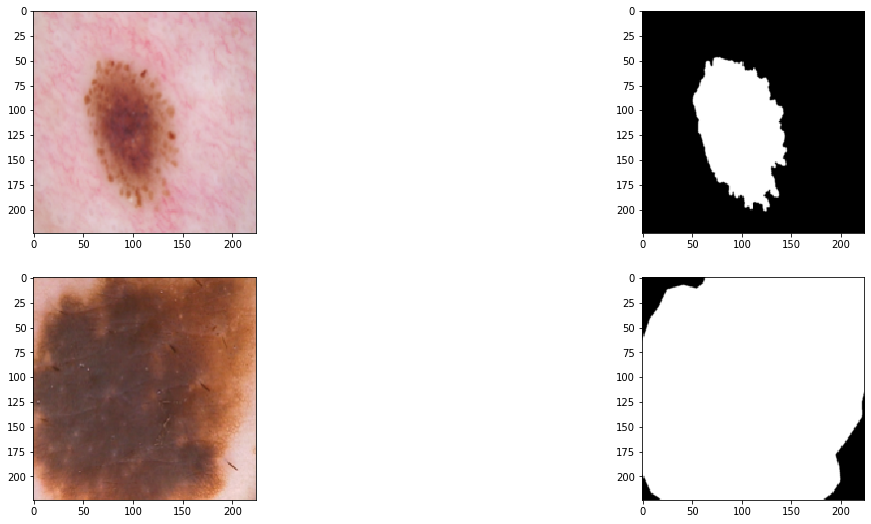

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

plt.figure(figsize=(20,9))
plt.subplot(2,2,1)
plt.imshow(images[0].permute(1, 2, 0))
plt.subplot(2,2,2)
plt.imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
plt.subplot(2,2,3)
plt.imshow(images[1].permute(1, 2, 0))
plt.subplot(2,2,4)
plt.imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# f, axarr = plt.subplots(2,2)
# axarr[0,0].imshow(images[0].permute(1, 2, 0)  )
# axarr[0,1].imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[1,0].imshow(images[1].permute(1, 2, 0)  )
# axarr[1,1].imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[2,0].imshow(images[2].permute(1, 2, 0)  )
# axarr[2,1].imshow(labels[2].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[3,0].imshow(images[3].permute(1, 2, 0)  )
# axarr[3,1].imshow(labels[3].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')

# Model

In [ ]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.activation = nn.Sigmoid()

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = self.activation(d1)
        return d1


In [ ]:

learning_rate = 0.001
from torchsummary import summary
model = AttU_Net().to(device)
#print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)#, momentum = 0.9, weight_decay = 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5, last_epoch=-1, verbose=True)
summary(model, (3,224,224))

Adjusting learning rate of group 0 to 1.0000e-03.


IndexError: ignored

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='attentionunet_2016_wda.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('attentionunet_2016_wda.pth'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
n_epochs = 70
patience = 7
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

[ 1/70] train_loss: 0.46009 valid_loss: 0.31952
Validation loss decreased (inf --> 0.319516).  Saving model ...
[ 2/70] train_loss: 0.30399 valid_loss: 0.24423
Validation loss decreased (0.319516 --> 0.244227).  Saving model ...
[ 3/70] train_loss: 0.26039 valid_loss: 0.22103
Validation loss decreased (0.244227 --> 0.221026).  Saving model ...
[ 4/70] train_loss: 0.23286 valid_loss: 0.20275
Validation loss decreased (0.221026 --> 0.202747).  Saving model ...
[ 5/70] train_loss: 0.21798 valid_loss: 0.18599
Validation loss decreased (0.202747 --> 0.185991).  Saving model ...
[ 6/70] train_loss: 0.21118 valid_loss: 0.18058
Validation loss decreased (0.185991 --> 0.180577).  Saving model ...
[ 7/70] train_loss: 0.20109 valid_loss: 0.17060
Validation loss decreased (0.180577 --> 0.170598).  Saving model ...
[ 8/70] train_loss: 0.18715 valid_loss: 0.17125
EarlyStopping counter: 1 out of 7
[ 9/70] train_loss: 0.18401 valid_loss: 0.17625
EarlyStopping counter: 2 out of 7
[10/70] train_loss: 0.

# Save and Load Model

In [ ]:
PATH = 'UNet_ISIC2016_wo_da.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# #to load weights
model = AttU_Net().to(device)
PATH = 'attentionunet_2016_wda.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
#only of the lesion class not the mean. 
"""
Evaluation Criteria:
1. Accuracy
2. IntersectionoverUnion(Jaccard Index)
4. Dice coefficient(F1-score)
6. Specificity
7. Sensitivity
"""

def compute_tp_tn_fn_fp(pred, label):
    '''
    True positive - actual = 1, predicted = 1
    False positive - actual = 1, predicted = 0
    False negative - actual = 0, predicted = 1
    True negative - actual = 0, predicted = 0
    '''
    pred = pred.cpu().numpy().astype('int32')
    label = label.cpu().numpy().astype('int32')
    tp = np.sum((label == 1) & (pred == 1))
    tn = np.sum((label == 0) & (pred == 0))
    fn = np.sum((label == 1) & (pred == 0))
    fp = np.sum((label == 0) & (pred == 1))
    return tp, tn, fp, fn

#2 preferred
def compute_acc(tp, tn, fp, fn):
    return ((tp+tn)/(tp+tn+fp+fn))

def compute_iou(tp, tn, fp, fn):
    return (tp/(tp+fp+fn))

def compute_dc(tp, tn, fp, fn):
    return ((2*tp)/(2*tp + fp+fn))

def compute_meaniou(tp, tn, fp, fn):
    a = (tp/(tp+fp+fn))
    b = (tn/(tn+fn+fp))
    return ((a+b)/2)

def compute_meandc(tp, tn, fp, fn):
    a = ((2*tp)/(2*tp + fp + fn))
    b = ((2*tn)/(2*tn + fp + fn))
    return (a+b)/2

def compute_prec(tp, tn, fp, fn):
    return (tp/(tp + fp + 1e-5))

def compute_rec(tp, tn, fp, fn):
    return (tp/(tp + fn + 1e-5))

def compute_specificity(tp, tn, fp, fn):
    return (tn/(tn + fp))

def compute_sensitivity(tp, tn, fp, fn):
    return (tp/(tp + fn))


def evaluate_model(pred, label):
    tp, tn, fp, fn = compute_tp_tn_fn_fp(pred, label)
    
    acc = compute_acc(tp, tn, fp, fn)
    iou = compute_iou(tp, tn, fp, fn)
    dc  = compute_dc(tp, tn, fp, fn)
#     miou = compute_meaniou(tp, tn, fp, fn)
#     mdc  = compute_meandc(tp, tn, fp, fn)
#     prec = compute_prec(tp, tn, fp, fn)
#     rec = compute_rec(tp, tn, fp, fn)
    spec = compute_specificity(tp, tn, fp, fn)
    sen = compute_sensitivity(tp, tn, fp, fn)
    
    return acc, iou, dc, spec, sen #, miou, mdc, prec, rec


In [ ]:
#evaluate model

model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Training Data______________________________________________'''
    print('Training Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
    specificity = 0
    sensitivity = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    
    '''______________________________Evaluating Validation Data____________________________________________'''
    print('Validation Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    specificity = 0
    sensitivity = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    

Training Data
Accuracy      : |   97.05  |
IoU           : |   90.30  |
DC            : |   94.89  |
Specificity   : |   97.24  |
Sensitivity   : |   96.42  |
-----------------------------------
Validation Data
Accuracy      : |   95.42  |
IoU           : |   84.91  |
DC            : |   91.78  |
Specificity   : |   96.14  |
Sensitivity   : |   93.40  |
-----------------------------------


Testing Data
--------------------------------------------------
Accuracy       :|   94.39  |
IoU            :|   80.32  |
DC             :|   87.92  |
Mean IoU       :|   94.65  |
Mean DC        :|   93.27  |
--------------------------------------------------
Visualizing Results


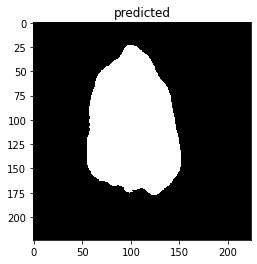

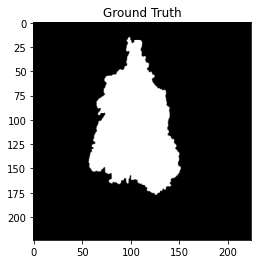

In [ ]:
#on Test Set

workbook = xlsxwriter.Workbook('attentionunet_2016_wda.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write(0, 0, "Image_name")
worksheet.write(0, 1, "Acc")
worksheet.write(0, 2, "IoU")
worksheet.write(0, 3, "DC")
worksheet.write(0, 4, "Spec")
worksheet.write(0, 5, "Sen")
# worksheet.write(0, 6, "Prec")
# worksheet.write(0, 7, "Rec")
row = 1
col = 0


model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Testing Data_______________________________________________'''
    print('Testing Data')
    
    acc_sum = []
    iou_sum = []
    dc_sum = []
    speci_sum = []
    sens_sum = []
#     miou_sum = []
#     mdc_sum = []
#     prec_sum = []
#     rec_sum = []
    
    for images, labels, image_name in test_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)

#         Saving the predicted Images
        pred_image = outputs.clone().detach()
        pred_image = pred_image.reshape(labels.shape[1], labels.shape[2], labels.shape[3])
        pred_image *= 255
        path = os.path.join("/content/drive/MyDrive/segmentation/AttentionUnet/BTPAttentionUnet/"+image_name[0])
        save_image(pred_image, path)
#         img = Image.fromarray(pred_image)
#         img.save(os.path.join("predicted_image/"+image_name))
#         im1 = Image.save("predicted_image/", image_name) 
        
#         Computing evaluation metrics
        output_image = outputs[0]
        label_image = labels[0]
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        acc_sum.append(acc)
        iou_sum.append(iou)
        dc_sum.append(dc)
        speci_sum.append(spec)
        sens_sum.append(sen)
#         prec_sum.append(prec)
#         rec_sum.append(rec)
        
        #writing the data in excel sheet
        col = 0
        worksheet.write(row, col, image_name[0])
        temp = "{:.2f}".format(acc*100)
        worksheet.write(row, col+1, temp)
        temp = "{:.2f}".format(iou*100)
        worksheet.write(row, col+2, temp)
        temp = "{:.2f}".format(dc*100)
        worksheet.write(row, col+3, temp)
        temp = "{:.2f}".format(spec*100)
        worksheet.write(row, col+4, temp)
        temp = "{:.2f}".format(sen*100)
        worksheet.write(row, col+5, temp)
#         temp = "{:.2f}".format(prec*100)
#         worksheet.write(row, col+6, temp)
#         temp = "{:.2f}".format(rec*100)
#         worksheet.write(row, col+7, temp)
        row += 1
        
#         print('---------------------')
#         print(image_name)
#         print('Accuracy :{:.2f} '.format(acc*100))
#         print('IoU      :{:.2f} '.format(iou*100))
#         print('dc       :{:.2f} '.format(dc*100))
#         print('miou     :{:.2f} '.format(miou*100))
#         print('mdc      :{:.2f} '.format(mdc*100))
#         print('prec     :{:.2f} '.format(prec*100))
#         print('Rec      :{:.2f} '.format(rec*100))
#         print('---------------------')
    
    acc = sum(acc_sum)/len(acc_sum)
    iou = sum(iou_sum)/len(iou_sum)
    dc = sum(dc_sum)/len(dc_sum)
    spec = sum(speci_sum)/len(speci_sum)
    sen = sum(sens_sum)/len(sens_sum)
#     prec = sum(prec_sum)/len(prec_sum)
#     rec = sum(rec_sum)/len(rec_sum)
    
    print('--------------------------------------------------')
    print('Accuracy       :|   {:.2f}  |'.format(acc*100))
    print('IoU            :|   {:.2f}  |'.format(iou*100))
    print('DC             :|   {:.2f}  |'.format(dc*100))
    print('Mean IoU       :|   {:.2f}  |'.format(spec*100))
    print('Mean DC        :|   {:.2f}  |'.format(sen*100))
#     print('Precision      :|   {:.2f}  |'.format(prec*100))
#     print('Recall         :|   {:.2f}  |'.format(rec*100))
    print('--------------------------------------------------')
    print("Visualizing Results")
    output_image = output_image*255
    label_image = label_image*255
    plt.figure(1)
    plt.imshow(output_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("predicted")
    plt.figure(2)
    plt.imshow(label_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("Ground Truth")
    
workbook.close()        

In [ ]:
# Loss Graph
plt.figure(1)
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss Graph')
plt.show()
plt.figure(2)
plt.plot(valid_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Validation Loss Graph')
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>